In [2]:
from machine import Machine
from GymMachEnv import MachineEnv

# Code from scratch

reference: https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py

# Verify

In [61]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# machine = Machine()
# machine.curr_state = 0
# env = MachineEnv(machine)

# state_size = env.observation_space.shape[0]
# action_size = env.action_space.n
# lr = 0.0001

env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


def trainIters(actor, critic, n_iters):
    optimizerA = optim.Adam(actor.parameters())
    optimizerC = optim.Adam(critic.parameters())
    score_list = []
    for iter in range(n_iters): #episode loop
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        for i in count(): #number of steps is equivalent to number of rewards

            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state

            if done:
                print('Iteration: {}, Score: {}'.format(iter, i))
                score_list.append(i)
                break

        
        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)  #Q value
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
#     torch.save(actor, 'actor.pkl')
#     torch.save(critic, 'critic.pkl')
    env.close()
    return score_list

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

def plot(score):
    df = pd.DataFrame(score)
    moving_ave = df.rolling(10,min_periods=1).mean().values.flatten().tolist()

    ep = [i for i in range(len(score))]
    fig = plt.figure(figsize=(10,10))
    plt.plot(ep,score,label = 'Episodic Reward')
    plt.plot(ep,moving_ave,label = f'Moving Average Window {10}')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()

In [63]:
ac = Actor(state_size,action_size)
critic = Critic(state_size,action_size)
score = trainIters(ac,critic,1000)

Iteration: 0, Score: 20
Iteration: 1, Score: 11
Iteration: 2, Score: 19
Iteration: 3, Score: 11
Iteration: 4, Score: 27
Iteration: 5, Score: 9
Iteration: 6, Score: 14
Iteration: 7, Score: 16
Iteration: 8, Score: 15
Iteration: 9, Score: 12
Iteration: 10, Score: 23
Iteration: 11, Score: 11
Iteration: 12, Score: 8
Iteration: 13, Score: 30
Iteration: 14, Score: 16
Iteration: 15, Score: 47
Iteration: 16, Score: 22
Iteration: 17, Score: 39
Iteration: 18, Score: 14
Iteration: 19, Score: 35
Iteration: 20, Score: 13
Iteration: 21, Score: 15
Iteration: 22, Score: 51
Iteration: 23, Score: 15
Iteration: 24, Score: 78
Iteration: 25, Score: 35
Iteration: 26, Score: 60
Iteration: 27, Score: 16
Iteration: 28, Score: 19
Iteration: 29, Score: 11
Iteration: 30, Score: 15
Iteration: 31, Score: 27
Iteration: 32, Score: 10
Iteration: 33, Score: 57
Iteration: 34, Score: 30
Iteration: 35, Score: 34
Iteration: 36, Score: 20
Iteration: 37, Score: 45
Iteration: 38, Score: 19
Iteration: 39, Score: 23
Iteration: 4

Iteration: 311, Score: 199
Iteration: 312, Score: 199
Iteration: 313, Score: 199
Iteration: 314, Score: 199
Iteration: 315, Score: 199
Iteration: 316, Score: 183
Iteration: 317, Score: 199
Iteration: 318, Score: 199
Iteration: 319, Score: 199
Iteration: 320, Score: 199
Iteration: 321, Score: 187
Iteration: 322, Score: 199
Iteration: 323, Score: 199
Iteration: 324, Score: 199
Iteration: 325, Score: 199
Iteration: 326, Score: 199
Iteration: 327, Score: 199
Iteration: 328, Score: 199
Iteration: 329, Score: 199
Iteration: 330, Score: 199
Iteration: 331, Score: 199
Iteration: 332, Score: 199
Iteration: 333, Score: 199
Iteration: 334, Score: 199
Iteration: 335, Score: 199
Iteration: 336, Score: 199
Iteration: 337, Score: 199
Iteration: 338, Score: 199
Iteration: 339, Score: 199
Iteration: 340, Score: 199
Iteration: 341, Score: 199
Iteration: 342, Score: 199
Iteration: 343, Score: 199
Iteration: 344, Score: 199
Iteration: 345, Score: 199
Iteration: 346, Score: 199
Iteration: 347, Score: 199
I

Iteration: 615, Score: 199
Iteration: 616, Score: 199
Iteration: 617, Score: 199
Iteration: 618, Score: 199
Iteration: 619, Score: 199
Iteration: 620, Score: 199
Iteration: 621, Score: 199
Iteration: 622, Score: 199
Iteration: 623, Score: 199
Iteration: 624, Score: 199
Iteration: 625, Score: 199
Iteration: 626, Score: 199
Iteration: 627, Score: 199
Iteration: 628, Score: 199
Iteration: 629, Score: 199
Iteration: 630, Score: 199
Iteration: 631, Score: 199
Iteration: 632, Score: 199
Iteration: 633, Score: 199
Iteration: 634, Score: 199
Iteration: 635, Score: 199
Iteration: 636, Score: 199
Iteration: 637, Score: 199
Iteration: 638, Score: 199
Iteration: 639, Score: 199
Iteration: 640, Score: 199
Iteration: 641, Score: 199
Iteration: 642, Score: 199
Iteration: 643, Score: 199
Iteration: 644, Score: 199
Iteration: 645, Score: 199
Iteration: 646, Score: 199
Iteration: 647, Score: 76
Iteration: 648, Score: 199
Iteration: 649, Score: 199
Iteration: 650, Score: 199
Iteration: 651, Score: 199
It

Iteration: 919, Score: 199
Iteration: 920, Score: 199
Iteration: 921, Score: 199
Iteration: 922, Score: 199
Iteration: 923, Score: 199
Iteration: 924, Score: 199
Iteration: 925, Score: 199
Iteration: 926, Score: 199
Iteration: 927, Score: 199
Iteration: 928, Score: 199
Iteration: 929, Score: 199
Iteration: 930, Score: 199
Iteration: 931, Score: 199
Iteration: 932, Score: 199
Iteration: 933, Score: 199
Iteration: 934, Score: 199
Iteration: 935, Score: 199
Iteration: 936, Score: 199
Iteration: 937, Score: 199
Iteration: 938, Score: 199
Iteration: 939, Score: 199
Iteration: 940, Score: 199
Iteration: 941, Score: 199
Iteration: 942, Score: 199
Iteration: 943, Score: 199
Iteration: 944, Score: 199
Iteration: 945, Score: 199
Iteration: 946, Score: 199
Iteration: 947, Score: 199
Iteration: 948, Score: 199
Iteration: 949, Score: 199
Iteration: 950, Score: 199
Iteration: 951, Score: 199
Iteration: 952, Score: 199
Iteration: 953, Score: 199
Iteration: 954, Score: 199
Iteration: 955, Score: 199
I

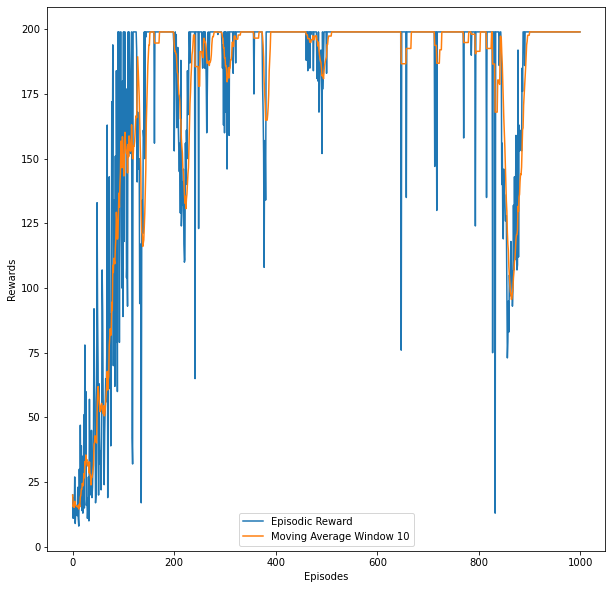

In [64]:
plot(score)

# Implementation

In [55]:
def trainItersMachine(actor, critic, n_iters,env):
    optimizerA = optim.Adam(actor.parameters(),lr=0.0003)
    optimizerC = optim.Adam(critic.parameters(),lr=0.0003)
    score_list = []
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()
        done = False

        while done == False: #number of steps is equivalent to number of rewards
            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state

            if done:
                print('Iteration: {}, Score: {}'.format(iter, sum(rewards)))
                score_list.append(sum(rewards))
                break


        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
    torch.save(actor, 'actor.pkl')
    torch.save(critic, 'critic.pkl')
    env.close()
    return score_list

In [57]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

ac2 = Actor(state_size,action_size)
critic2 = Critic(state_size,action_size)
scoreMach = trainItersMachine(ac2,critic2,2000,env)


Iteration: 0, Score: tensor([41900.])
Iteration: 1, Score: tensor([47200.])
Iteration: 2, Score: tensor([200.])
Iteration: 3, Score: tensor([14200.])
Iteration: 4, Score: tensor([5300.])
Iteration: 5, Score: tensor([6500.])
Iteration: 6, Score: tensor([48800.])
Iteration: 7, Score: tensor([8600.])
Iteration: 8, Score: tensor([23000.])
Iteration: 9, Score: tensor([800.])
Iteration: 10, Score: tensor([23000.])
Iteration: 11, Score: tensor([7900.])
Iteration: 12, Score: tensor([24300.])
Iteration: 13, Score: tensor([35200.])
Iteration: 14, Score: tensor([5500.])
Iteration: 15, Score: tensor([2200.])
Iteration: 16, Score: tensor([13100.])
Iteration: 17, Score: tensor([1000.])
Iteration: 18, Score: tensor([36200.])
Iteration: 19, Score: tensor([45100.])
Iteration: 20, Score: tensor([5300.])
Iteration: 21, Score: tensor([32000.])
Iteration: 22, Score: tensor([27100.])
Iteration: 23, Score: tensor([42500.])
Iteration: 24, Score: tensor([27600.])
Iteration: 25, Score: tensor([41200.])
Iteratio

Iteration: 209, Score: tensor([6000.])
Iteration: 210, Score: tensor([17000.])
Iteration: 211, Score: tensor([42900.])
Iteration: 212, Score: tensor([49400.])
Iteration: 213, Score: tensor([3400.])
Iteration: 214, Score: tensor([23900.])
Iteration: 215, Score: tensor([3300.])
Iteration: 216, Score: tensor([2900.])
Iteration: 217, Score: tensor([10600.])
Iteration: 218, Score: tensor([6400.])
Iteration: 219, Score: tensor([11400.])
Iteration: 220, Score: tensor([22300.])
Iteration: 221, Score: tensor([1200.])
Iteration: 222, Score: tensor([3800.])
Iteration: 223, Score: tensor([18200.])
Iteration: 224, Score: tensor([6500.])
Iteration: 225, Score: tensor([24100.])
Iteration: 226, Score: tensor([25300.])
Iteration: 227, Score: tensor([52400.])
Iteration: 228, Score: tensor([20100.])
Iteration: 229, Score: tensor([38800.])
Iteration: 230, Score: tensor([24300.])
Iteration: 231, Score: tensor([6500.])
Iteration: 232, Score: tensor([47200.])
Iteration: 233, Score: tensor([0.])
Iteration: 23

Iteration: 416, Score: tensor([36600.])
Iteration: 417, Score: tensor([20300.])
Iteration: 418, Score: tensor([7800.])
Iteration: 419, Score: tensor([48400.])
Iteration: 420, Score: tensor([53800.])
Iteration: 421, Score: tensor([21300.])
Iteration: 422, Score: tensor([11300.])
Iteration: 423, Score: tensor([43100.])
Iteration: 424, Score: tensor([30200.])
Iteration: 425, Score: tensor([42800.])
Iteration: 426, Score: tensor([22900.])
Iteration: 427, Score: tensor([19700.])
Iteration: 428, Score: tensor([1800.])
Iteration: 429, Score: tensor([700.])
Iteration: 430, Score: tensor([18100.])
Iteration: 431, Score: tensor([5900.])
Iteration: 432, Score: tensor([27500.])
Iteration: 433, Score: tensor([9300.])
Iteration: 434, Score: tensor([23600.])
Iteration: 435, Score: tensor([38900.])
Iteration: 436, Score: tensor([24700.])
Iteration: 437, Score: tensor([13800.])
Iteration: 438, Score: tensor([52600.])
Iteration: 439, Score: tensor([30000.])
Iteration: 440, Score: tensor([11700.])
Iterat

Iteration: 623, Score: tensor([21300.])
Iteration: 624, Score: tensor([26300.])
Iteration: 625, Score: tensor([37400.])
Iteration: 626, Score: tensor([7400.])
Iteration: 627, Score: tensor([34200.])
Iteration: 628, Score: tensor([-1000.])
Iteration: 629, Score: tensor([20900.])
Iteration: 630, Score: tensor([5600.])
Iteration: 631, Score: tensor([28000.])
Iteration: 632, Score: tensor([10500.])
Iteration: 633, Score: tensor([40100.])
Iteration: 634, Score: tensor([1700.])
Iteration: 635, Score: tensor([0.])
Iteration: 636, Score: tensor([17900.])
Iteration: 637, Score: tensor([38300.])
Iteration: 638, Score: tensor([8300.])
Iteration: 639, Score: tensor([5300.])
Iteration: 640, Score: tensor([21600.])
Iteration: 641, Score: tensor([31400.])
Iteration: 642, Score: tensor([15100.])
Iteration: 643, Score: tensor([42500.])
Iteration: 644, Score: tensor([4300.])
Iteration: 645, Score: tensor([30200.])
Iteration: 646, Score: tensor([11000.])
Iteration: 647, Score: tensor([26500.])
Iteration:

Iteration: 831, Score: tensor([14000.])
Iteration: 832, Score: tensor([1400.])
Iteration: 833, Score: tensor([31900.])
Iteration: 834, Score: tensor([42800.])
Iteration: 835, Score: tensor([51000.])
Iteration: 836, Score: tensor([15600.])
Iteration: 837, Score: tensor([2500.])
Iteration: 838, Score: tensor([7300.])
Iteration: 839, Score: tensor([22000.])
Iteration: 840, Score: tensor([4800.])
Iteration: 841, Score: tensor([27000.])
Iteration: 842, Score: tensor([37200.])
Iteration: 843, Score: tensor([1600.])
Iteration: 844, Score: tensor([0.])
Iteration: 845, Score: tensor([49200.])
Iteration: 846, Score: tensor([42900.])
Iteration: 847, Score: tensor([30600.])
Iteration: 848, Score: tensor([10500.])
Iteration: 849, Score: tensor([24200.])
Iteration: 850, Score: tensor([30900.])
Iteration: 851, Score: tensor([19400.])
Iteration: 852, Score: tensor([6800.])
Iteration: 853, Score: tensor([11600.])
Iteration: 854, Score: tensor([29400.])
Iteration: 855, Score: tensor([300.])
Iteration: 8

Iteration: 1037, Score: tensor([17400.])
Iteration: 1038, Score: tensor([41800.])
Iteration: 1039, Score: tensor([14200.])
Iteration: 1040, Score: tensor([2900.])
Iteration: 1041, Score: tensor([-300.])
Iteration: 1042, Score: tensor([8400.])
Iteration: 1043, Score: tensor([900.])
Iteration: 1044, Score: tensor([-1000.])
Iteration: 1045, Score: tensor([49400.])
Iteration: 1046, Score: tensor([500.])
Iteration: 1047, Score: tensor([8300.])
Iteration: 1048, Score: tensor([10800.])
Iteration: 1049, Score: tensor([-1000.])
Iteration: 1050, Score: tensor([37500.])
Iteration: 1051, Score: tensor([29100.])
Iteration: 1052, Score: tensor([-800.])
Iteration: 1053, Score: tensor([15300.])
Iteration: 1054, Score: tensor([20100.])
Iteration: 1055, Score: tensor([6500.])
Iteration: 1056, Score: tensor([26800.])
Iteration: 1057, Score: tensor([14500.])
Iteration: 1058, Score: tensor([10600.])
Iteration: 1059, Score: tensor([57300.])
Iteration: 1060, Score: tensor([19700.])
Iteration: 1061, Score: te

Iteration: 1239, Score: tensor([23100.])
Iteration: 1240, Score: tensor([54000.])
Iteration: 1241, Score: tensor([29200.])
Iteration: 1242, Score: tensor([21000.])
Iteration: 1243, Score: tensor([27600.])
Iteration: 1244, Score: tensor([48500.])
Iteration: 1245, Score: tensor([7300.])
Iteration: 1246, Score: tensor([41000.])
Iteration: 1247, Score: tensor([13400.])
Iteration: 1248, Score: tensor([6800.])
Iteration: 1249, Score: tensor([-1000.])
Iteration: 1250, Score: tensor([36400.])
Iteration: 1251, Score: tensor([5600.])
Iteration: 1252, Score: tensor([7000.])
Iteration: 1253, Score: tensor([0.])
Iteration: 1254, Score: tensor([53700.])
Iteration: 1255, Score: tensor([58000.])
Iteration: 1256, Score: tensor([43100.])
Iteration: 1257, Score: tensor([3000.])
Iteration: 1258, Score: tensor([16200.])
Iteration: 1259, Score: tensor([500.])
Iteration: 1260, Score: tensor([13100.])
Iteration: 1261, Score: tensor([30700.])
Iteration: 1262, Score: tensor([26900.])
Iteration: 1263, Score: ten

Iteration: 1441, Score: tensor([55700.])
Iteration: 1442, Score: tensor([7300.])
Iteration: 1443, Score: tensor([41200.])
Iteration: 1444, Score: tensor([20300.])
Iteration: 1445, Score: tensor([2400.])
Iteration: 1446, Score: tensor([1400.])
Iteration: 1447, Score: tensor([15100.])
Iteration: 1448, Score: tensor([3600.])
Iteration: 1449, Score: tensor([5900.])
Iteration: 1450, Score: tensor([56700.])
Iteration: 1451, Score: tensor([5000.])
Iteration: 1452, Score: tensor([3600.])
Iteration: 1453, Score: tensor([57400.])
Iteration: 1454, Score: tensor([53100.])
Iteration: 1455, Score: tensor([6800.])
Iteration: 1456, Score: tensor([16300.])
Iteration: 1457, Score: tensor([7500.])
Iteration: 1458, Score: tensor([2600.])
Iteration: 1459, Score: tensor([13100.])
Iteration: 1460, Score: tensor([30000.])
Iteration: 1461, Score: tensor([23500.])
Iteration: 1462, Score: tensor([33600.])
Iteration: 1463, Score: tensor([400.])
Iteration: 1464, Score: tensor([34900.])
Iteration: 1465, Score: tens

Iteration: 1643, Score: tensor([6300.])
Iteration: 1644, Score: tensor([4100.])
Iteration: 1645, Score: tensor([55800.])
Iteration: 1646, Score: tensor([6800.])
Iteration: 1647, Score: tensor([-500.])
Iteration: 1648, Score: tensor([48000.])
Iteration: 1649, Score: tensor([20700.])
Iteration: 1650, Score: tensor([5900.])
Iteration: 1651, Score: tensor([0.])
Iteration: 1652, Score: tensor([14700.])
Iteration: 1653, Score: tensor([22300.])
Iteration: 1654, Score: tensor([13300.])
Iteration: 1655, Score: tensor([18000.])
Iteration: 1656, Score: tensor([35100.])
Iteration: 1657, Score: tensor([20000.])
Iteration: 1658, Score: tensor([1400.])
Iteration: 1659, Score: tensor([33100.])
Iteration: 1660, Score: tensor([18800.])
Iteration: 1661, Score: tensor([5700.])
Iteration: 1662, Score: tensor([24400.])
Iteration: 1663, Score: tensor([11100.])
Iteration: 1664, Score: tensor([41700.])
Iteration: 1665, Score: tensor([-2100.])
Iteration: 1666, Score: tensor([42100.])
Iteration: 1667, Score: ten

Iteration: 1846, Score: tensor([49400.])
Iteration: 1847, Score: tensor([3500.])
Iteration: 1848, Score: tensor([2700.])
Iteration: 1849, Score: tensor([-1000.])
Iteration: 1850, Score: tensor([5300.])
Iteration: 1851, Score: tensor([400.])
Iteration: 1852, Score: tensor([200.])
Iteration: 1853, Score: tensor([9700.])
Iteration: 1854, Score: tensor([28400.])
Iteration: 1855, Score: tensor([42600.])
Iteration: 1856, Score: tensor([4800.])
Iteration: 1857, Score: tensor([11300.])
Iteration: 1858, Score: tensor([44900.])
Iteration: 1859, Score: tensor([16600.])
Iteration: 1860, Score: tensor([12200.])
Iteration: 1861, Score: tensor([7800.])
Iteration: 1862, Score: tensor([12100.])
Iteration: 1863, Score: tensor([3500.])
Iteration: 1864, Score: tensor([37500.])
Iteration: 1865, Score: tensor([32500.])
Iteration: 1866, Score: tensor([8900.])
Iteration: 1867, Score: tensor([6600.])
Iteration: 1868, Score: tensor([-1800.])
Iteration: 1869, Score: tensor([53500.])
Iteration: 1870, Score: tenso

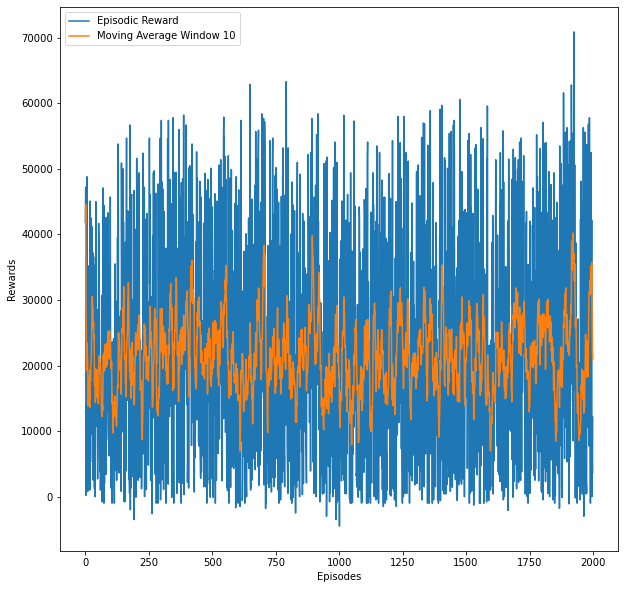

In [58]:
plot(scoreMach)

In [65]:
sum(scoreMach)/len(scoreMach)

tensor([21471.7500])

# Using Baseline API

In [ ]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines.common.env_checker import check_env

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv
machine = Machine()
machine.curr_state = 0
env = DummyVecEnv([lambda: MachineEnv(machine)])

In [ ]:
check_env(env)

In [ ]:
model = A2C('MlpLstmPolicy', env).learn(total_timesteps=3000)

In [ ]:
obs = env.reset()

In [ ]:
env.step([0])

In [ ]:
obs = env.reset()
for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(action,rewards)

In [ ]:
action